In [1]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline.data.sentdex import sentiment
from quantopian.pipeline.data.morningstar import operation_ratios 
from quantopian.pipeline.data.morningstar import balance_sheet

In [42]:
def make_pipeline():
    
    testing_factor1 = operation_ratios.net_margin.latest
    testing_factor2 = sentiment.sentiment_signal.latest
    testing_factor3 = operation_ratios.revenue_growth.latest
    #testing_factor4 = -balance_sheet.bank_indebtedness.latest

    universe = (Q1500US() & 
               testing_factor1.notnull() &
               testing_factor2.notnull() &
               testing_factor3.notnull()) # &
               #testing_factor4.notnull()) 
    
    testing_factor1 = testing_factor1.rank(mask=universe, method = "average")
    testing_factor2 = testing_factor2.rank(mask=universe, method = "average")
    testing_factor3 = testing_factor3.rank(mask=universe, method = "average")
    #testing_factor4 = testing_factor4.rank(mask=universe, method = "average")

    
    testing_factor = testing_factor1 + testing_factor2 + testing_factor3 #- testing_factor4
    
    testing_quantiles = testing_factor.quantiles(2)
    
    pipe = Pipeline(columns={
                            "testing_factor": testing_factor, 
                            "shorts": testing_quantiles.eq(0), 
                            "longs": testing_quantiles.eq(1)},
                            screen=universe)
    return pipe 



In [43]:
result = run_pipeline(make_pipeline(), start_date = "2015-01-01", end_date = "2016-01-01")

In [44]:
result.head()

longs shorts  testing_factor
2015-01-02 00:00:00+00:00 Equity(2 [ARNC])   False   True           761.0
                          Equity(24 [AAPL])   True  False          1188.0
                          Equity(62 [ABT])    True  False           813.5
                          Equity(67 [ADSK])   True  False           957.0
                          Equity(76 [TAP])   False   True           173.5

In [45]:
assets = result.index.levels[1].unique()
pricing = get_pricing(assets, start_date = "2014-12-01", end_date = "2016-02-01", fields = "open_price")

In [46]:
import alphalens
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor = result["testing_factor"],
                                                                  prices = pricing,
                                                                  quantiles = 3,
                                                                  periods = (1,10,30))

Dropped 4.7% entries from factor data: 4.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Returns Analysis


,1D,10D,30D
Ann. alpha,0.129,0.114,0.099
beta,-0.064,-0.159,-0.204
Mean Period Wise Return Top Quantile (bps),2.647,2.654,2.962
Mean Period Wise Return Bottom Quantile (bps),-5.305,-4.923,-4.585
Mean Period Wise Spread (bps),7.952,7.598,7.579


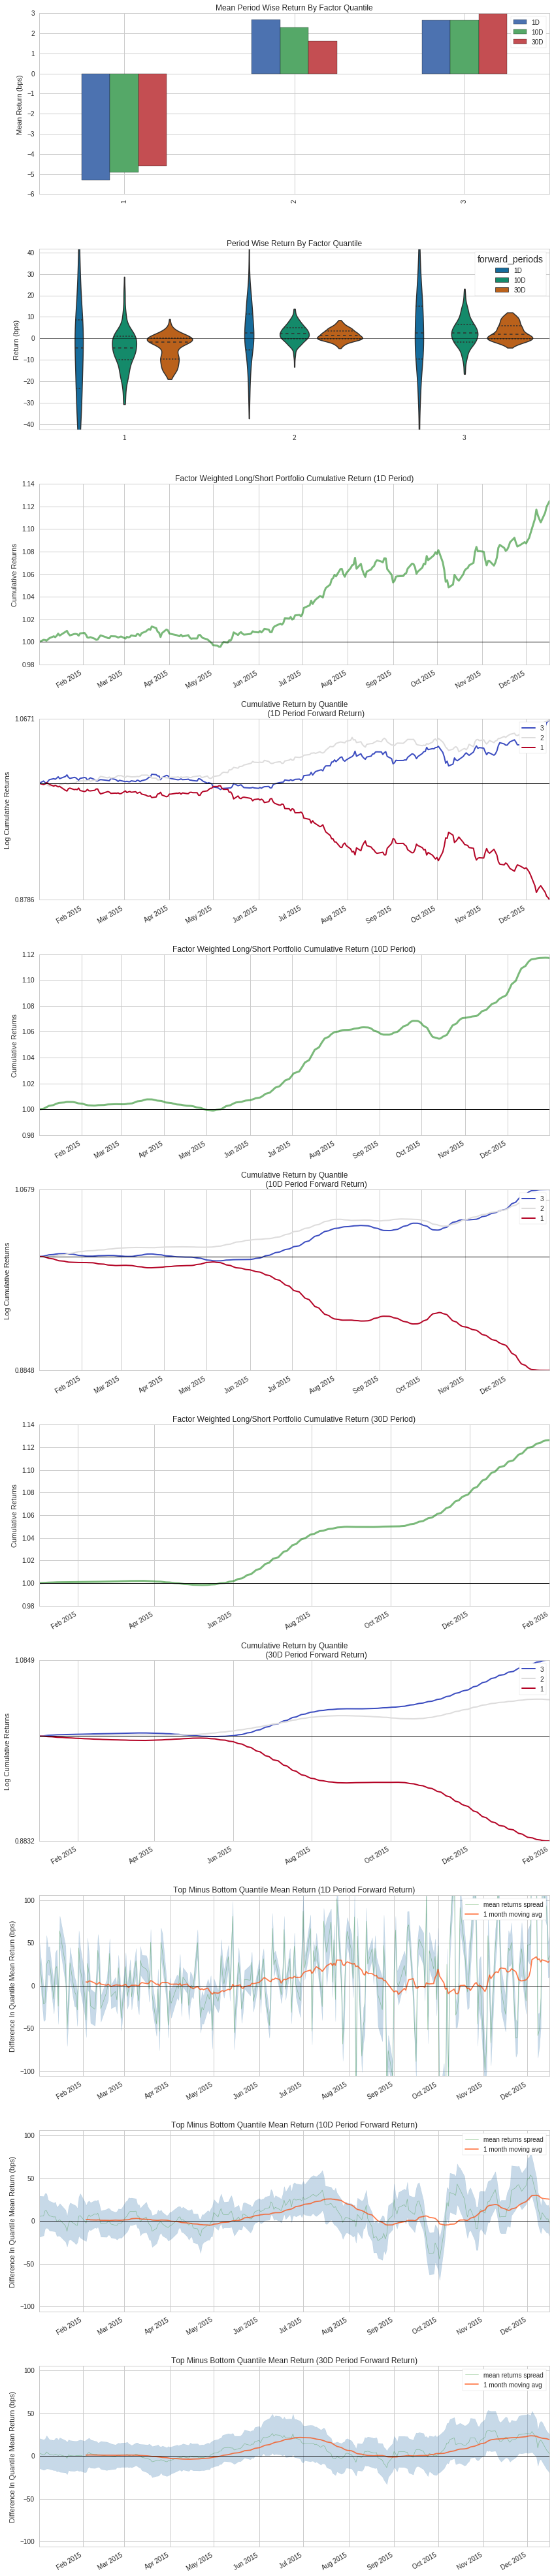

In [47]:
alphalens.tears.create_returns_tear_sheet(factor_data)